In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,GlobalMaxPooling1D,LSTM, GRU
from tensorflow.keras.models import Sequential

In [ ]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [ ]:
df.shape

(50000, 2)

In [ ]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [ ]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [ ]:
### You can convert the sequences back to the string 
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [ ]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [ ]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [ ]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]])

In [ ]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [ ]:
type(x_val)

numpy.ndarray

In [ ]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


In [ ]:
print(x_train.shape,x_val.shape,x_test.shape)

(36000, 256) (4000, 256) (10000, 256)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

#The parameters for embedding layer: embedding_dim=64, num_embeddings/ input_dim(Keras)=10000 since we only kept the 10000 most frequent words

In [ ]:
# #add an Embedding layer as the first layer
# model = keras.Sequential()
# model.add(Embedding(input_dim=10000, output_dim=64, input_length=256))

a) Use Vanilla RNN with hidden_dimension=64 followed by a one neuron FC layer with a
sigmoid activation

In [ ]:
model_rnn= Sequential()
model_rnn.add(Embedding(input_dim=10000, output_dim=64, input_length=256))
model_rnn.add(SimpleRNN(units=64))
model_rnn.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model_rnn.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the model
pred_history_rnn=model_rnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 86s 149ms/step - loss: 0.5895 - accuracy: 0.6756 - val_loss: 0.4679 - val_accuracy: 0.7865
Epoch 2/10
563/563 [==============================] - 76s 135ms/step - loss: 0.4024 - accuracy: 0.8286 - val_loss: 0.3860 - val_accuracy: 0.8330
Epoch 3/10
563/563 [==============================] - 77s 136ms/step - loss: 0.3095 - accuracy: 0.8780 - val_loss: 0.3367 - val_accuracy: 0.8605
Epoch 4/10
563/563 [==============================] - 74s 131ms/step - loss: 0.2463 - accuracy: 0.9082 - val_loss: 0.3137 - val_accuracy: 0.8737
Epoch 5/10
563/563 [==============================] - 78s 138ms/step - loss: 0.1972 - accuracy: 0.9322 - val_loss: 0.3239 - val_accuracy: 0.8777
Epoch 6/10
563/563 [==============================] - 73s 129ms/step - loss: 0.1633 - accuracy: 0.9464 - val_loss: 0.3221 - val_accuracy: 0.8783
Epoch 7/10
563/563 [==============================] - 71s 127ms/step - loss: 0.1341 - accuracy: 0.9580 - val_loss: 0.3387 - val_ac

In [ ]:
#Report the performance of each network in terms of test accuracy and also plot the validation loss vs
#train loss, and validation accuracy vs train accuracy for all of the following tasks.

In [ ]:
test_accuracy_rnn = model_rnn.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_rnn[1] * 100.0))



Test Accuracy: 85.72


In [ ]:
val_accuracy_rnn = model_rnn.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_rnn[1] * 100.0))

Val Accuracy: 86.80


In [ ]:
#Plot Train vs Validation Accuracy
def TrainVsVal_acc(pred_history):
    plt.figure(figsize=(4, 6))
    plt.plot(np.arange(0, 10), pred_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, 10), pred_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
#Plot Train vs Validation Loss
def trainVsVal_Loss(pred_history):
    plt.figure(figsize=(4, 6))
    plt.plot(np.arange(0, 10), pred_history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 10), pred_history.history["val_loss"], label="val_loss")
    plt.title("Training Loss vs Validation Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

 Train vs Val Accuracy for RNN1


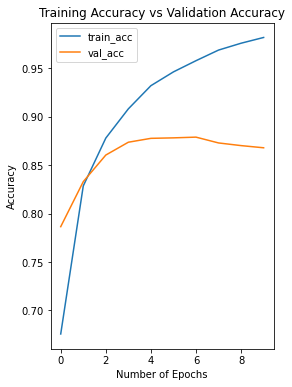

 Train vs Val loss for RNN1


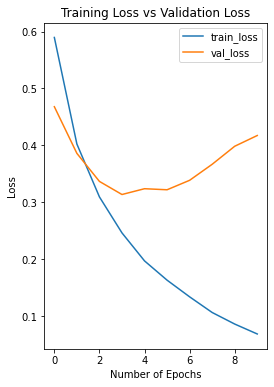

In [ ]:
print(" Train vs Val Accuracy for RNN1")
TrainVsVal_acc(pred_history_rnn)
print(" Train vs Val loss for RNN1")
trainVsVal_Loss(pred_history_rnn)

b) Use Vanilla RNN with hidden_dimension=64, followed by Global maxpool 1d, followed by
FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid function

In [ ]:
# Define the model architecture
model_RNN2 = Sequential()
model_RNN2.add(Embedding(input_dim=10000, output_dim=64))
model_RNN2.add(SimpleRNN(units=64, return_sequences=True))
model_RNN2.add(GlobalMaxPooling1D())
model_RNN2.add(Dense(units=16, activation='relu'))
model_RNN2.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model_RNN2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [ ]:
# Train the model
pred_history_rnn2=model_RNN2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 92s 158ms/step - loss: 0.6917 - accuracy: 0.5428 - val_loss: 0.6290 - val_accuracy: 0.6910
Epoch 2/10
563/563 [==============================] - 87s 154ms/step - loss: 0.4598 - accuracy: 0.7993 - val_loss: 0.3719 - val_accuracy: 0.8410
Epoch 3/10
563/563 [==============================] - 92s 163ms/step - loss: 0.3144 - accuracy: 0.8760 - val_loss: 0.3321 - val_accuracy: 0.8627
Epoch 4/10
563/563 [==============================] - 88s 156ms/step - loss: 0.2500 - accuracy: 0.9076 - val_loss: 0.3068 - val_accuracy: 0.8758
Epoch 5/10
563/563 [==============================] - 87s 154ms/step - loss: 0.2115 - accuracy: 0.9248 - val_loss: 0.3261 - val_accuracy: 0.8755
Epoch 6/10
563/563 [==============================] - 83s 147ms/step - loss: 0.1844 - accuracy: 0.9364 - val_loss: 0.3219 - val_accuracy: 0.8652
Epoch 7/10
563/563 [==============================] - 85s 151ms/step - loss: 0.1620 - accuracy: 0.9452 - val_loss: 0.3420 - val_ac

In [ ]:
test_accuracy_rnn2 = model_RNN2.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_rnn2[1] * 100.0))

Test Accuracy: 86.35


In [ ]:
val_accuracy_rnn2 = model_RNN2.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_rnn2[1] * 100.0))

Val Accuracy: 85.93


 Train vs Val Accuracy for RNN2


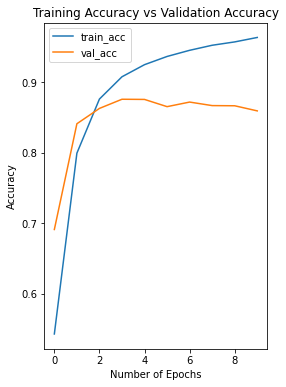

 Train vs Val loss for RNN2


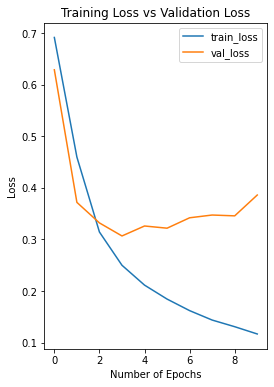

In [ ]:
print(" Train vs Val Accuracy for RNN2")
TrainVsVal_acc(pred_history_rnn2)
print(" Train vs Val loss for RNN2")
trainVsVal_Loss(pred_history_rnn2)

2. a) Use LSTM with hidden_dimension=64 followed by a one neuron FC layer with a sigmoid
activation.

In [ ]:
model_LSTM = Sequential()

# Add an embedding layer
model_LSTM.add(Embedding(input_dim=10000, output_dim=64))
model_LSTM.add(LSTM(units=64))
model_LSTM.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model_LSTM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the summary of the model architecture
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
pred_history_LSTM=model_LSTM.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 293s 507ms/step - loss: 0.5207 - accuracy: 0.7386 - val_loss: 0.3296 - val_accuracy: 0.8725
Epoch 2/10
563/563 [==============================] - 286s 508ms/step - loss: 0.2847 - accuracy: 0.8901 - val_loss: 0.2785 - val_accuracy: 0.8915
Epoch 3/10
563/563 [==============================] - 285s 507ms/step - loss: 0.2301 - accuracy: 0.9152 - val_loss: 0.2661 - val_accuracy: 0.8960
Epoch 4/10
563/563 [==============================] - 287s 511ms/step - loss: 0.1972 - accuracy: 0.9307 - val_loss: 0.2731 - val_accuracy: 0.8928
Epoch 5/10
563/563 [==============================] - 211s 374ms/step - loss: 0.1741 - accuracy: 0.9407 - val_loss: 0.3107 - val_accuracy: 0.8845
Epoch 6/10
563/563 [==============================] - 164s 292ms/step - loss: 0.1600 - accuracy: 0.9471 - val_loss: 0.3035 - val_accuracy: 0.8863
Epoch 7/10
563/563 [==============================] - 154s 274ms/step - loss: 0.1433 - accuracy: 0.9546 - val_loss: 0.3257 -

In [ ]:
test_accuracy_lstm = model_LSTM.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_lstm[1] * 100.0))

Test Accuracy: 87.53


In [ ]:
val_accuracy_lstm = model_LSTM.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_lstm[1] * 100.0))

Val Accuracy: 88.10


 Train vs Val Accuracy for LSTM


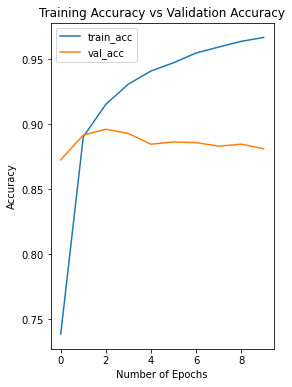

 Train vs Val loss for LSTM


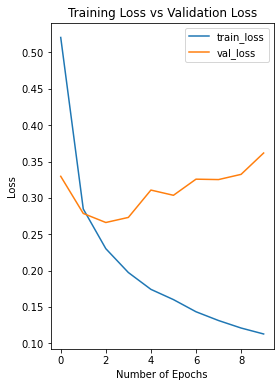

In [ ]:
print(" Train vs Val Accuracy for LSTM")
TrainVsVal_acc(pred_history_LSTM)
print(" Train vs Val loss for LSTM")
trainVsVal_Loss(pred_history_LSTM)

2.b)Use LSTM with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with
16 neurons with ReLU, followed by FC layer with single output with sigmoid function.

In [ ]:
# Define the model architecture
model_LSTM2 = Sequential()
model_LSTM2.add(Embedding(input_dim=10000, output_dim=64))
model_LSTM2.add(LSTM(units=64, return_sequences=True))
model_LSTM2.add(GlobalMaxPooling1D())
model_LSTM2.add(Dense(units=16, activation='relu'))
model_LSTM2.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model_LSTM2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the summary of the model architecture
model_LSTM2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 674,081
Trainable params: 674,081
Non-trainable params: 0
________________________________________________

In [ ]:
# Train the model
pred_history_LSTM2=model_LSTM2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 194s 338ms/step - loss: 0.5906 - accuracy: 0.7108 - val_loss: 0.4188 - val_accuracy: 0.8393
Epoch 2/10
563/563 [==============================] - 234s 415ms/step - loss: 0.3510 - accuracy: 0.8665 - val_loss: 0.3269 - val_accuracy: 0.8760
Epoch 3/10
563/563 [==============================] - 235s 417ms/step - loss: 0.2725 - accuracy: 0.8984 - val_loss: 0.3132 - val_accuracy: 0.8820
Epoch 4/10
563/563 [==============================] - 222s 394ms/step - loss: 0.2294 - accuracy: 0.9137 - val_loss: 0.3021 - val_accuracy: 0.8817
Epoch 5/10
563/563 [==============================] - 224s 398ms/step - loss: 0.2017 - accuracy: 0.9267 - val_loss: 0.3153 - val_accuracy: 0.8832
Epoch 6/10
563/563 [==============================] - 224s 398ms/step - loss: 0.1808 - accuracy: 0.9362 - val_loss: 0.2998 - val_accuracy: 0.8823
Epoch 7/10
563/563 [==============================] - 224s 397ms/step - loss: 0.1647 - accuracy: 0.9439 - val_loss: 0.3349 -

In [ ]:
test_accuracy_LSTM2 = model_LSTM2.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_LSTM2[1] * 100.0))

Test Accuracy: 86.64


In [ ]:
val_accuracy_LSTM2 = model_LSTM2.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_LSTM2[1] * 100.0))

Val Accuracy: 87.17


 Train vs Val Accuracy for LSTM2


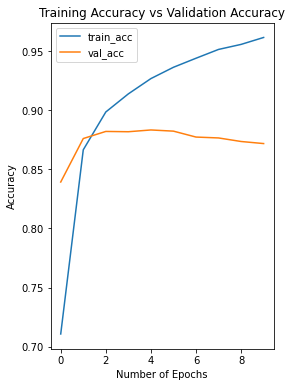

 Train vs Val loss for LSTM2


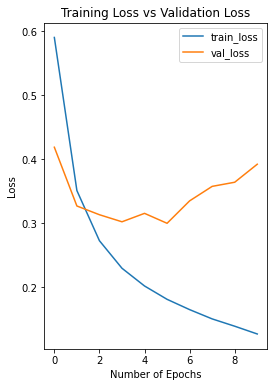

In [ ]:
print(" Train vs Val Accuracy for LSTM2")
TrainVsVal_acc(pred_history_LSTM2)
print(" Train vs Val loss for LSTM2")
trainVsVal_Loss(pred_history_LSTM2)

2.C) Stacke two layers of LSTM, the output of stacked LSTM goes to Global maxpool 1d, followed
by FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid
function.

In [ ]:
# Define the model architecture
model_LSTM3 = Sequential()
model_LSTM3.add(Embedding(input_dim=10000, output_dim=64))
model_LSTM3.add(LSTM(units=64, return_sequences=True))
model_LSTM3.add(LSTM(units=64, return_sequences=True))
model_LSTM3.add(GlobalMaxPooling1D())
model_LSTM3.add(Dense(units=16, activation='relu'))
model_LSTM3.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model_LSTM3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the summary of the model architecture
model_LSTM3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          33024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                      

In [ ]:
# Train the model
pred_history_LSTM3=model_LSTM3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 5046s 9s/step - loss: 0.5094 - accuracy: 0.7374 - val_loss: 0.3419 - val_accuracy: 0.8547
Epoch 2/10
563/563 [==============================] - 393s 697ms/step - loss: 0.2790 - accuracy: 0.8897 - val_loss: 0.2929 - val_accuracy: 0.8873
Epoch 3/10
563/563 [==============================] - 395s 701ms/step - loss: 0.2258 - accuracy: 0.9160 - val_loss: 0.2932 - val_accuracy: 0.8832
Epoch 4/10
563/563 [==============================] - 408s 725ms/step - loss: 0.1942 - accuracy: 0.9290 - val_loss: 0.3019 - val_accuracy: 0.8773
Epoch 5/10
563/563 [==============================] - 400s 711ms/step - loss: 0.1743 - accuracy: 0.9391 - val_loss: 0.3441 - val_accuracy: 0.8775
Epoch 6/10
563/563 [==============================] - 406s 720ms/step - loss: 0.1574 - accuracy: 0.9469 - val_loss: 0.3484 - val_accuracy: 0.8748
Epoch 7/10
563/563 [==============================] - 401s 712ms/step - loss: 0.1434 - accuracy: 0.9516 - val_loss: 0.3554 - v

In [ ]:
test_accuracy_LSTM3 = model_LSTM3.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_LSTM3[1] * 100.0))

Test Accuracy: 86.33


In [ ]:
val_accuracy_LSTM3 = model_LSTM3.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_LSTM3[1] * 100.0))

Val Accuracy: 86.62


 Train vs Val Accuracy for LSTM3


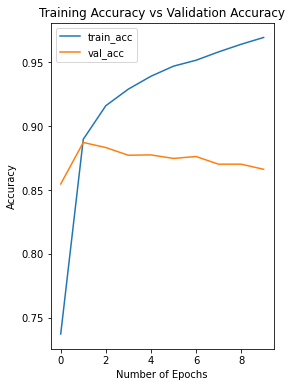

 Train vs Val loss for LSTM3


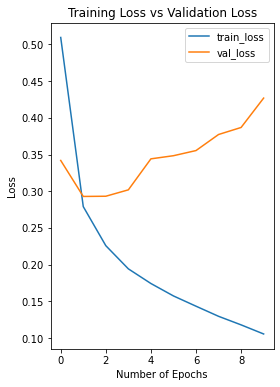

In [ ]:
print(" Train vs Val Accuracy for LSTM3")
TrainVsVal_acc(pred_history_LSTM3)
print(" Train vs Val loss for LSTM3")
trainVsVal_Loss(pred_history_LSTM3)

3.a) Use GRU with hidden_dimension=64 followed by a one neuron FC layer with a sigmoid
activation.

In [ ]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=10000, output_dim=64, input_length=256))
model_GRU.add(GRU(units=64))
model_GRU.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_GRU.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model_GRU.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 64)           640000    
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 665,025
Trainable params: 665,025
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the model
pred_history_GRU=model_GRU.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 212s 359ms/step - loss: 0.5652 - accuracy: 0.6959 - val_loss: 0.3165 - val_accuracy: 0.8775
Epoch 2/10
563/563 [==============================] - 186s 331ms/step - loss: 0.2700 - accuracy: 0.8922 - val_loss: 0.2650 - val_accuracy: 0.8935
Epoch 3/10
563/563 [==============================] - 190s 338ms/step - loss: 0.2143 - accuracy: 0.9194 - val_loss: 0.2559 - val_accuracy: 0.8970
Epoch 4/10
563/563 [==============================] - 187s 332ms/step - loss: 0.1843 - accuracy: 0.9317 - val_loss: 0.2585 - val_accuracy: 0.8967
Epoch 5/10
563/563 [==============================] - 182s 323ms/step - loss: 0.1633 - accuracy: 0.9431 - val_loss: 0.2735 - val_accuracy: 0.8925
Epoch 6/10
563/563 [==============================] - 190s 337ms/step - loss: 0.1468 - accuracy: 0.9499 - val_loss: 0.2783 - val_accuracy: 0.8915
Epoch 7/10
563/563 [==============================] - 188s 333ms/step - loss: 0.1346 - accuracy: 0.9562 - val_loss: 0.3093 -

In [ ]:
test_accuracy_GRU = model_GRU.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_GRU[1] * 100.0))

Test Accuracy: 87.63


In [ ]:
val_accuracy_GRU = model_GRU.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_GRU[1] * 100.0))

Val Accuracy: 88.70


 Train vs Val Accuracy for GRU


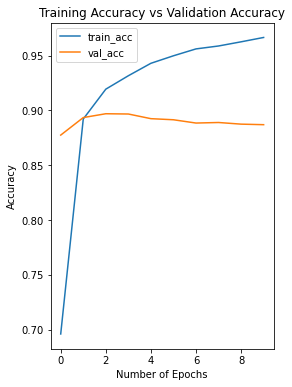

 Train vs Val loss for GRU


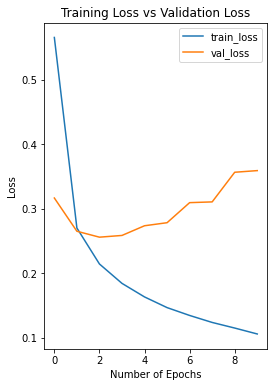

In [ ]:
print(" Train vs Val Accuracy for GRU")
TrainVsVal_acc(pred_history_GRU)
print(" Train vs Val loss for GRU")
trainVsVal_Loss(pred_history_GRU)

3. b) Use GRU with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with
16 neurons with ReLU, followed by FC layer with single output with sigmoid function.

In [ ]:
# Define the model architecture
model_GRU2 = Sequential()
model_GRU2.add(Embedding(input_dim=10000, output_dim=64))
model_GRU2.add(GRU(units=64, return_sequences=True))
model_GRU2.add(GlobalMaxPooling1D())
model_GRU2.add(Dense(units=16, activation='relu'))
model_GRU2.add(Dense(units=1, activation='sigmoid'))



# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_GRU2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model_GRU2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_1 (GRU)                 (None, None, 64)          24960     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 666,017
Trainable params: 666,017
Non-trainable params: 0
________________________________________________

In [ ]:
# Train the model
pred_history_GRU2=model_GRU2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
563/563 [==============================] - 211s 367ms/step - loss: 0.6359 - accuracy: 0.7112 - val_loss: 0.4250 - val_accuracy: 0.8580
Epoch 2/10
563/563 [==============================] - 197s 350ms/step - loss: 0.3519 - accuracy: 0.8653 - val_loss: 0.3095 - val_accuracy: 0.8770
Epoch 3/10
563/563 [==============================] - 197s 349ms/step - loss: 0.2627 - accuracy: 0.8993 - val_loss: 0.2806 - val_accuracy: 0.8845
Epoch 4/10
563/563 [==============================] - 197s 349ms/step - loss: 0.2233 - accuracy: 0.9179 - val_loss: 0.2776 - val_accuracy: 0.8892
Epoch 5/10
563/563 [==============================] - 201s 356ms/step - loss: 0.1983 - accuracy: 0.9289 - val_loss: 0.2826 - val_accuracy: 0.8852
Epoch 6/10
563/563 [==============================] - 203s 360ms/step - loss: 0.1779 - accuracy: 0.9385 - val_loss: 0.2876 - val_accuracy: 0.8863
Epoch 7/10
563/563 [==============================] - 199s 353ms/step - loss: 0.1622 - accuracy: 0.9454 - val_loss: 0.3024 -

In [ ]:
test_accuracy_GRU2 = model_GRU2.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy_GRU2[1] * 100.0))

Test Accuracy: 86.48


In [ ]:
val_accuracy_GRU2 = model_GRU2.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy_GRU2[1] * 100.0))

Val Accuracy: 86.85


 Train vs Val Accuracy for GRU2


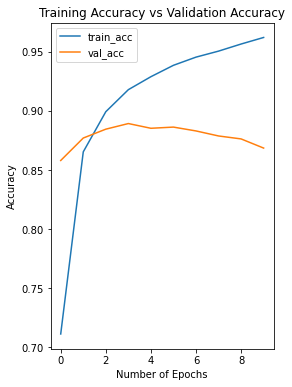

 Train vs Val loss for GRU2


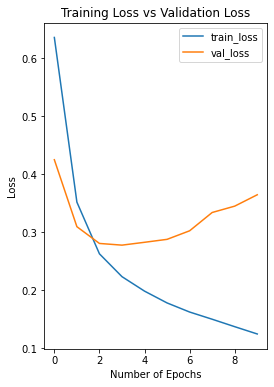

In [ ]:
print(" Train vs Val Accuracy for GRU2")
TrainVsVal_acc(pred_history_GRU2)
print(" Train vs Val loss for GRU2")
trainVsVal_Loss(pred_history_GRU2)